In [1]:
# !pip install albumentations

##  Imports

In [2]:
# Importar otros ipynb
import nbimporter

from torch.utils.data import Dataset, DataLoader

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2

import torch.nn as nn
import torch

from sklearn.metrics import accuracy_score

# Medir tiempos
import time

from torchvision.transforms import ToTensor

import numpy as np

# Ignoramos los warning
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

## Run otros ipynb

In [3]:
%run notebooks/Train/train.ipynb
%run notebooks/Validation/validation.ipynb
%run ./colormap.ipynb
%run ./notebooks/Train/params_train.ipynb

In [4]:
from notebooks.DataLoad.DataLoader import UNetDataset

## Carga de imagenes, lotes y visualización

In [5]:
# Rutas hacia las imagenes
train_img_folder = 'notebooks/DataLoad/Definitivas_modelo_corto/semantic_drone_dataset/train_imgs/original_images'
train_label_folder = 'notebooks/DataLoad/Definitivas_modelo_corto/semantic_drone_dataset/train_imgs/label_images_semantic'
test_img_folder = 'notebooks/DataLoad/Definitivas_modelo_corto/semantic_drone_dataset/test_imgs/original_images'
test_label_folder = 'notebooks/DataLoad/Definitivas_modelo_corto/semantic_drone_dataset/test_imgs/label_images_semantic'

train_dataset = UNetDataset(train_img_folder, train_label_folder)
test_dataset = UNetDataset(test_img_folder, test_label_folder)

In [6]:
# Creacion de los lotes
train_loader = DataLoader(train_dataset, batch_size=tam_lote, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=tam_lote, shuffle=True)

In [7]:
# Vemos los lotes que tenemos
print("Tenemos ", len(train_loader), " lotes de ", tam_lote, " imágenes para train")
print("Tenemos ", len(test_loader), " lotes de ", tam_lote, " imágenes para test")

Tenemos  131  lotes de  22  imágenes para train
Tenemos  44  lotes de  22  imágenes para test


torch.Size([256, 256, 3])
torch.Size([256, 256])


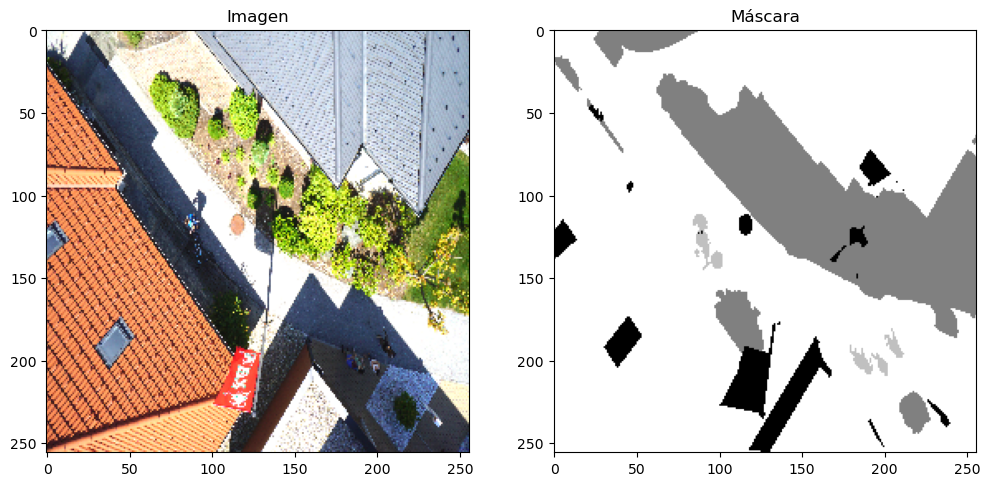

In [8]:
# Obtén el primer lote de datos del cargador de datos de entrenamiento
imagenes, mascaras = next(iter(train_loader))

# Selecciona la primera imagen y máscara del lote
imagen = imagenes[0]
mascara = mascaras[0]
        
print(imagen.size())
print(mascara.size())

# Ahora puedes visualizar la imagen y la máscara con imshow()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(imagen)
plt.title('Imagen')
plt.subplot(1, 2, 2)
plt.imshow(mascara, cmap='gray')
plt.title('Máscara')
plt.show()


## Comprobamos que las imagenes RGB estan escaladas en el rango [0-1]

In [9]:
print("El valor minimo que encontramos en la imagen RGB es: ",round(torch.min(imagen).item(),4), " y el valor máximo es: ",torch.max(imagen).item())

El valor minimo que encontramos en la imagen RGB es:  0.0392  y el valor máximo es:  1.0


## Comprobamos los valores de las máscaras

In [10]:
print("Los distintos valores que encontramos en Ground Truth  son: ",np.unique(mascara))

Los distintos valores que encontramos en Ground Truth  son:  [0 2 3 4]


## Vemos si tenemos GPU

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device,"\n")

cpu 



In [12]:
# Importo la clase donde creo el modelo
from notebooks.Model.unet import *

In [13]:
# Nº clases de salida son 5 los objetos a identificar: agua, vegetacion, obstaculo, movimiento y zona aterrizable
out_classes = 5

# Elección técnica de upsampling
# "conv_transpose" --> convolución transpuesta
# "bilinear" --> interpolación bilineal
# "maxunpooling" --> maxunpooling
upsample_tec = "conv_transpose"

# U-NET Model build
unet_model = UNet(out_classes)

In [14]:
# Inicialización de pesos al modelo
unet_model.apply(init_weights)

UNet(
  (down_1): DownsamplingBlock(
    (blockConv): BlockConv(
      (blockConv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_2): DownsamplingBlock(
    (blockConv): BlockConv(
      (blockConv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv

In [15]:
#!pip install torchsummary

In [16]:
from torchsummary import summary

# Asume que 'modelo' es tu modelo de red neuronal
summary(unet_model, input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
         LeakyReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
         LeakyReLU-6         [-1, 64, 256, 256]               0
         BlockConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
 DownsamplingBlock-9  [[-1, 64, 128, 128], [-1, 64, 256, 256]]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
        LeakyReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]         147,584
      BatchNorm2d-14    

## Entrenamiento y Validación

In [17]:
train_accs = []
test_accs = [] 

best_acc_val = 0
correctos_mejor = {}
    
optm = optim.Adam(unet_model.parameters(), lr= learning_rate)

t_ini = time.time()

for epoch in range(epochs):
    
    # Precision entrenamiento de la epoca
    train_loss = train_unet(unet_model, train_loader, optm, loss_crit, device)
    print(len(train_loss))
    train_acc = 1 -(sum(train_loss) / len(train_loss))
    train_accs.append(train_acc)
    print(f"Época {epoch + 1}, Precisión entrenamiento: {train_acc:.4f}")

    # Precisión validación
    test_acc, correctos_clase = validate_unet(unet_model, test_loader, loss_crit, device)
    test_accs.append(test_acc)
    print(f"Época {epoch + 1}, Precisión validación: {test_acc:.4f}")
    
    # Control de parada
    if test_acc > best_acc_val :
        correctos_mejor = correctos_clase
        best_acc_val = test_acc
        epoch_worst = 0
        torch.save(unet_model, "models/prueba_buena.pth")
        print(" ~ GUARDANDO MODELO ~ Obtenemos un test_acc = ", test_acc," %.")
    else:
        epoch_worst += 1
        
    
    if epoch_worst > stop:
        print(" ~~ DETENCIÓN DEL ENTRENAMIENTO ~~ Van ", epoch_worst, " épocas sin obtener mejora.")
    
t_fin = time.time()
print("\nEl tiempo de entrenamiento del modelo son: ", (t_fin-t_ini)/60, " minutos")

131
Época 1, Precisión entrenamiento: 0.3631
Época 1, Precisión validación: 79.2864
 ~ GUARDANDO MODELO ~ Obtenemos un test_acc =  79.28638617197673  %.
131
Época 2, Precisión entrenamiento: 0.4961
Época 2, Precisión validación: 80.4392
 ~ GUARDANDO MODELO ~ Obtenemos un test_acc =  80.43922583262125  %.
131
Época 3, Precisión entrenamiento: 0.5420
Época 3, Precisión validación: 75.5163
131
Época 4, Precisión entrenamiento: 0.5687
Época 4, Precisión validación: 61.6973
131
Época 5, Precisión entrenamiento: 0.6017
Época 5, Precisión validación: 72.6477
131
Época 6, Precisión entrenamiento: 0.6396
Época 6, Precisión validación: 71.2384
131
Época 7, Precisión entrenamiento: 0.6315
Época 7, Precisión validación: 84.1394
 ~ GUARDANDO MODELO ~ Obtenemos un test_acc =  84.1393518447876  %.
131
Época 8, Precisión entrenamiento: 0.6543
Época 8, Precisión validación: 85.0224
 ~ GUARDANDO MODELO ~ Obtenemos un test_acc =  85.02244313557942  %.
131
Época 9, Precisión entrenamiento: 0.6901
Época 9,

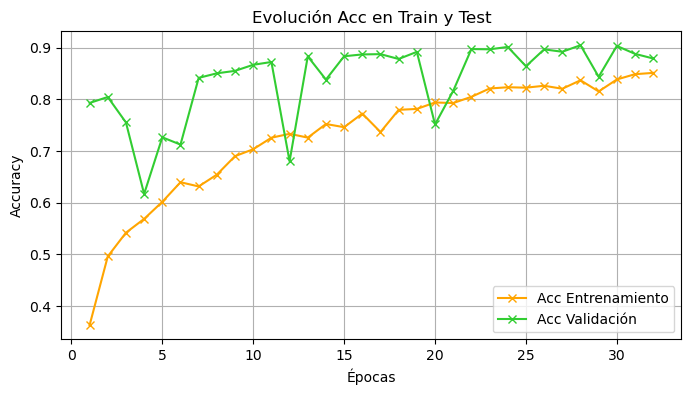

In [18]:
# Número de épocas
epocas = range(1, epochs + 1)

test_accs = [elemento / 100 for elemento in test_accs]
    
# Crear el gráfico
plt.figure(figsize=(8, 4))
plt.plot(epocas, train_accs, label='Acc Entrenamiento', marker='x', linestyle='-', color="#FFA500")
plt.plot(epocas, test_accs, label='Acc Validación', marker='x', linestyle='-', color="#32CD32")

# Etiquetas y título
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.title('Evolución Acc en Train y Test')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [27]:
correctos_mejor

{0: 3823856, 1: 1332302, 2: 23619941, 3: 421863, 4: 27711025}

## Visualización resultados

In [9]:
import torch.nn.functional as function

In [10]:
ruta_modelo = "models/prueba_buena.pth"

modelo = torch.load(ruta_modelo)

## Probabilidades predichas por el modelo

torch.Size([22, 5, 256, 256])


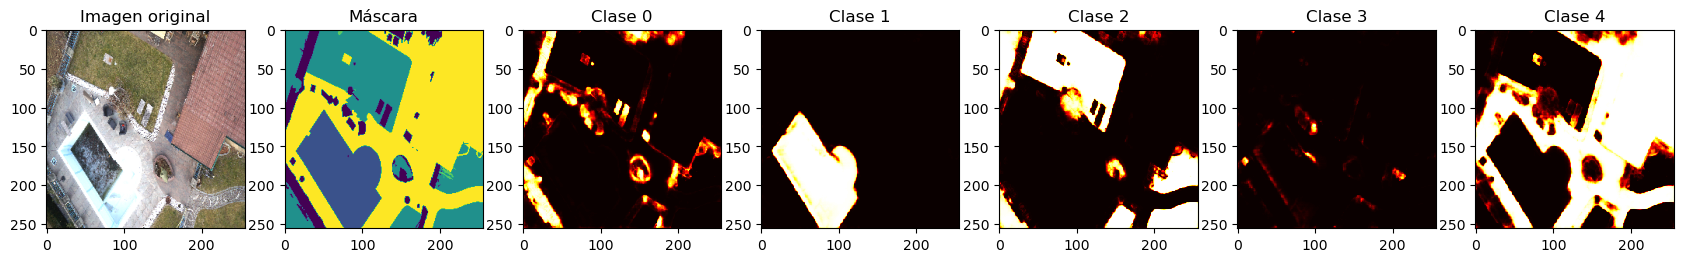

torch.Size([22, 5, 256, 256])


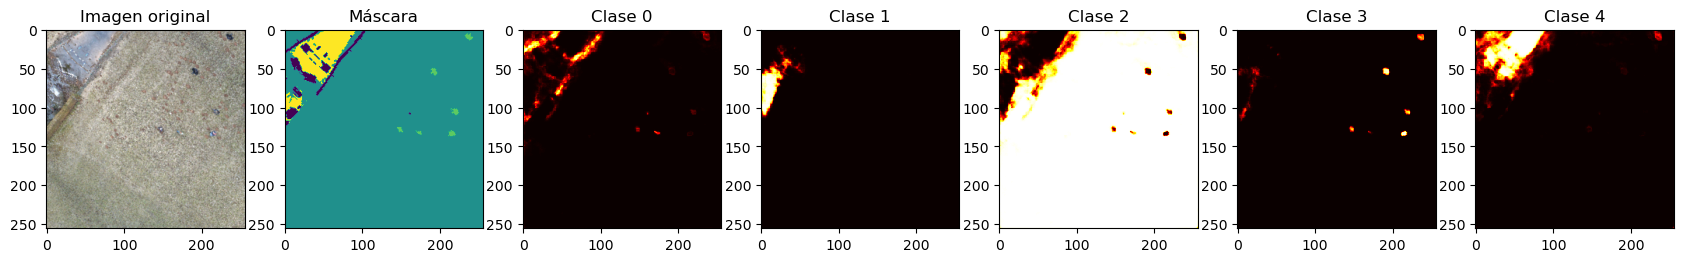

torch.Size([22, 5, 256, 256])


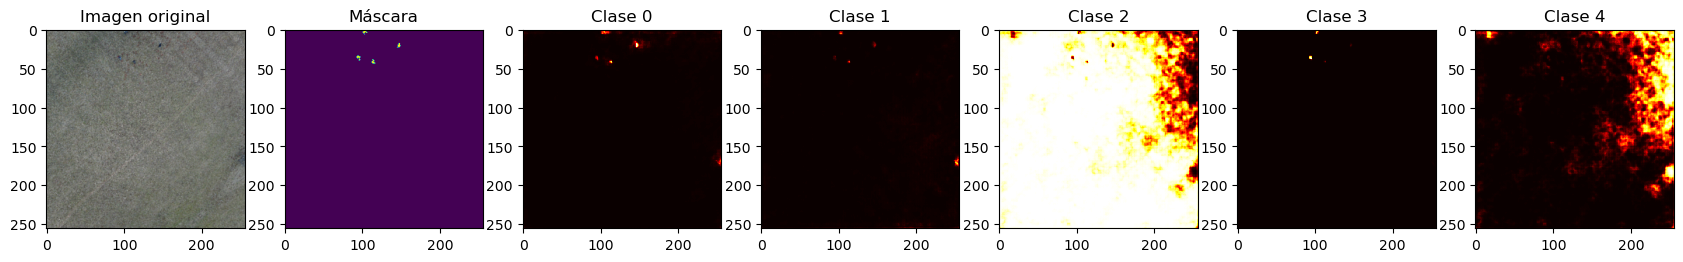

torch.Size([22, 5, 256, 256])


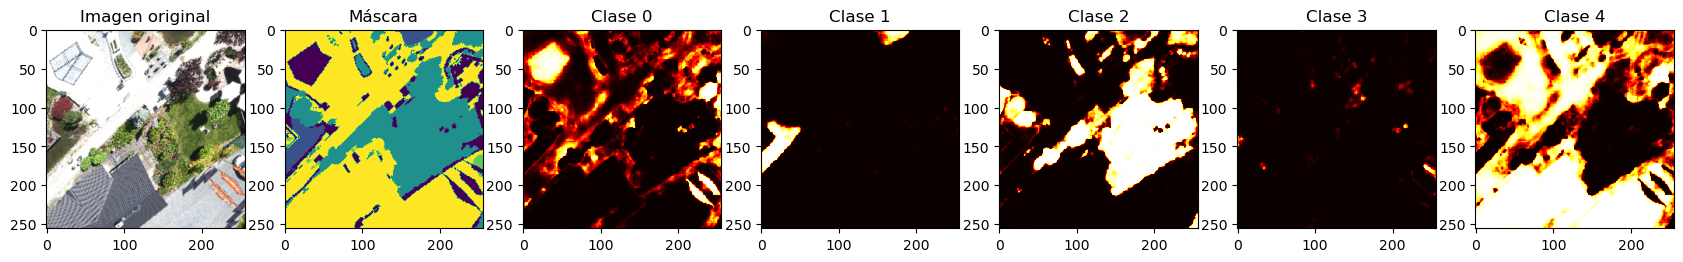

torch.Size([22, 5, 256, 256])


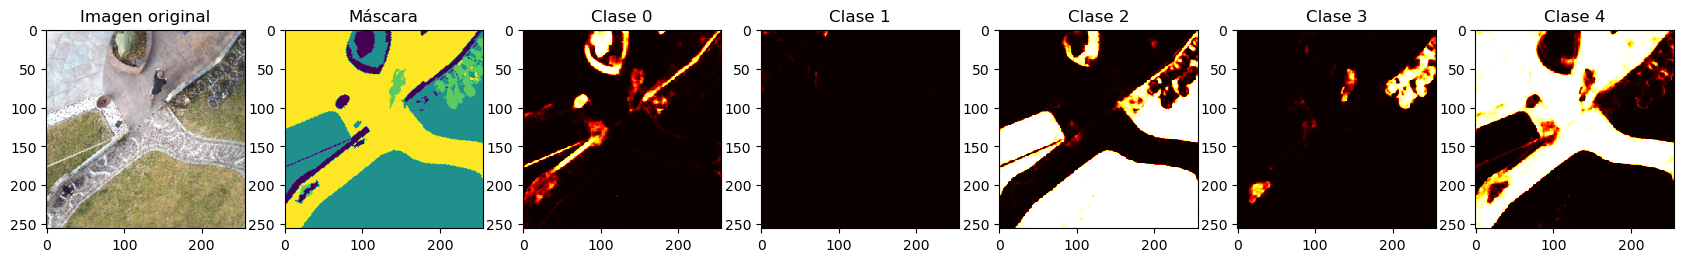

In [11]:
# Elimina la limitación de PyTorch al mostrar un tensor
torch.set_printoptions(profile="full")

modelo.eval()

stop_img = 0 

# Recorre las imágenes en el conjunto de datos de prueba
for batch_idx, (imagenes, mascaras) in enumerate(test_loader):

    # Permuta las dimensiones de las imágenes a (N, C, H, W)
    imagenes = imagenes.permute(0, 3, 1, 2)
    imagenes2 = imagenes.permute(0, 2, 3, 1)
    
    imagenes, mascaras = imagenes.to(device, dtype=torch.float), mascaras.to(device,  dtype=torch.long)
        
    # Realiza la predicción
    with torch.no_grad():
        outputs = modelo(imagenes)
        #print(outputs.size())
        
    # Aplica la función softmax para obtener las probabilidades
    probabilities = torch.softmax(outputs, dim=1)
    print(probabilities.size())
    
    # Crea una figura con subplots en una sola línea
    fig, axs = plt.subplots(1, 7, figsize=(21, 3))  # Ajusta el tamaño de la figura según sea necesario

    # Muestra la imagen original
    axs[0].imshow(imagenes2[0].cpu().numpy())
    axs[0].set_title("Imagen original")

    # Muestra la máscara
    axs[1].imshow(mascaras[0].cpu().numpy())
    axs[1].set_title("Máscara")

    # Muestra las probabilidades para cada clase
    for i in range(5):
        axs[i+2].imshow(probabilities[0, i].cpu().numpy(), cmap='hot', interpolation='nearest')
        axs[i+2].set_title(f"Clase {i}")

        
    stop_img += 1
    
    if(stop_img == 5):
        break
        
    # Muestra la figura
    plt.show()

In [43]:
%run notebooks/Opt/roc_treshold.ipynb

In [45]:
#umbrales = find_optimal_thresholds(modelo, test_loader, 5)

In [46]:
#print(umbrales)

NameError: name 'umbrales' is not defined